# Sampling from univariate and multivariate normal distributions using Box-Muller transform

- toc: true 
- badges: true
- comments: true
- author: Nipun Batra
- categories: [ML]

In this notebook I'll talk about sampling from univariate and multivariate normal distributions. I'll mostly directly write the code and show the output. The excellent linked references provide the background.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import tensorflow_probability as tfp
import pandas as pd
tfd = tfp.distributions
tfl = tfp.layers
tfb = tfp.bijectors

sns.reset_defaults()
sns.set_context(context='talk',font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Sampling from a univariate normal

The goal here is to sample from $\mathcal{N}(\mu, \sigma^2)$. The key idea is to use samples from a uniform distribution to first get samples for a standard normal $\mathcal{N}(0, 1)$ and then apply an affine transformation to get samples for $\mathcal{N}(\mu, \sigma^2)$.

#### Sampling from uniform distribution

In [2]:
U = tf.random.uniform((1000, 2))
U1, U2 = U[:, 0], U[:, 1]

2022-02-04 12:00:15.559198: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Applying the Box-Muller transform

In [3]:
X1 = tf.sqrt(-2*tf.math.log(U1))*tf.cos(2*np.pi*U2)
X2 = tf.sqrt(-2*tf.math.log(U1))*tf.sin(2*np.pi*U2)

In [4]:
X = tf.concat((X1, X2), axis=0)
X.shape

TensorShape([2000])

#### Plotting the obtained standard normal

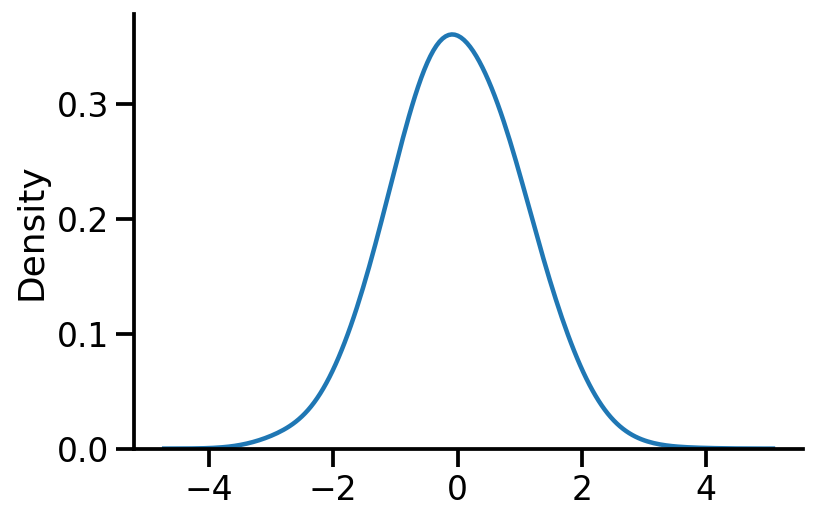

In [5]:
sns.kdeplot(X, bw_adjust=2)
sns.despine()

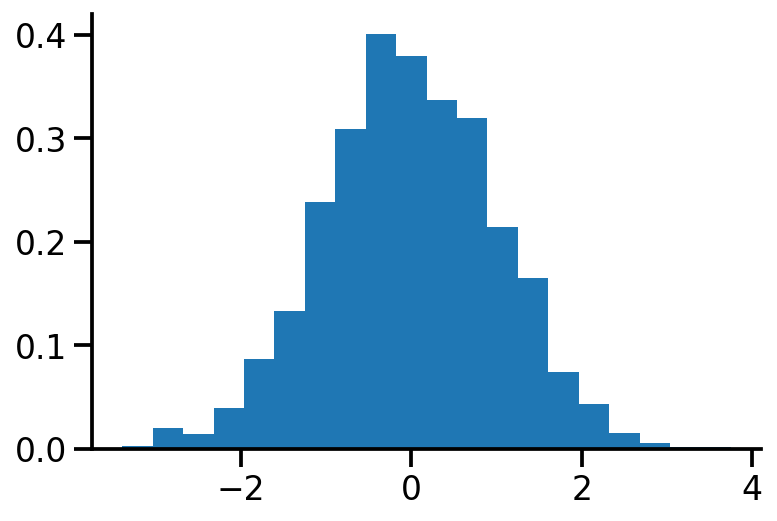

In [6]:
plt.hist(X.numpy(), bins=20, density=True)
sns.despine()

#### Sampling from $\mathcal{N}(\mu, \sigma^2)$ 

We apply the affine transformation.

$X \sim \mathcal{N}(0, 1)$

$Y \sim \mathcal{N}(\mu, \sigma^2)$ is equivalent to $Y \sim \mu + \sigma X$


In [7]:
mu = 2.
sigma = 2.
Y = mu + sigma*X

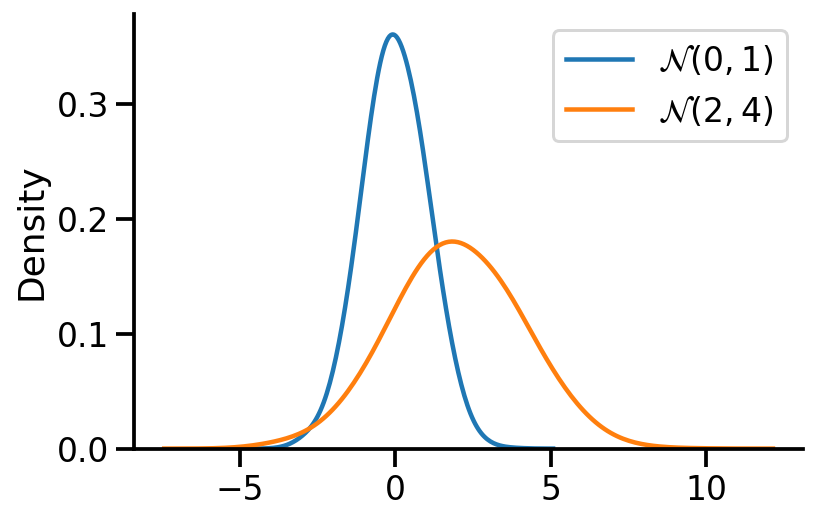

In [8]:
ax = sns.kdeplot(X, label=r'$\mathcal{N}(0, 1)$', bw_adjust=2)
sns.kdeplot(Y, label=r'$\mathcal{N}(2, 4)$', bw_adjust=2)
sns.despine()
plt.legend()

### Sampling from multivariate normal

Like before, we first sample from standard multivariate normal and then apply an affine transformation to get for our desired multivariate normal.

The important thing to note in the generation of the standard multivariate normal samples is that the individial random variables are independent of each other given the identity covariance matrix. Thus, we can independently generate the samples for individual random variable.

In [9]:
U_2D_Samples = tf.random.uniform((2, 1000, 2))

In [10]:
U11, U12, U21, U22 = U_2D_Samples[0, :, 0], U_2D_Samples[0, :, 1],U_2D_Samples[1, :, 0],U_2D_Samples[1, :, 1]

In [11]:
def generate(U1, U2):
    X1 = tf.sqrt(-2*tf.math.log(U1))*tf.cos(2*np.pi*U2)
    X2 = tf.sqrt(-2*tf.math.log(U1))*tf.sin(2*np.pi*U2)
    X = tf.concat((X1, X2), axis=0)
    return X

In [12]:
X_1 = tf.reshape(generate(U11, U12), (-1, 1))
X_2 = tf.reshape(generate(U21, U22), (-1, 1))

In [13]:
X = tf.concat((X_1, X_2), axis=1)

In [14]:
X

<tf.Tensor: shape=(2000, 2), dtype=float32, numpy=
array([[-1.2652589 , -1.4106055 ],
       [ 0.09925841, -0.12048604],
       [ 0.73987466,  1.8815755 ],
       ...,
       [-0.05203251,  1.1814289 ],
       [-0.04060707, -0.14595209],
       [-0.7659936 ,  1.505757  ]], dtype=float32)>

#### Plotting samples from generated standard 2d normal

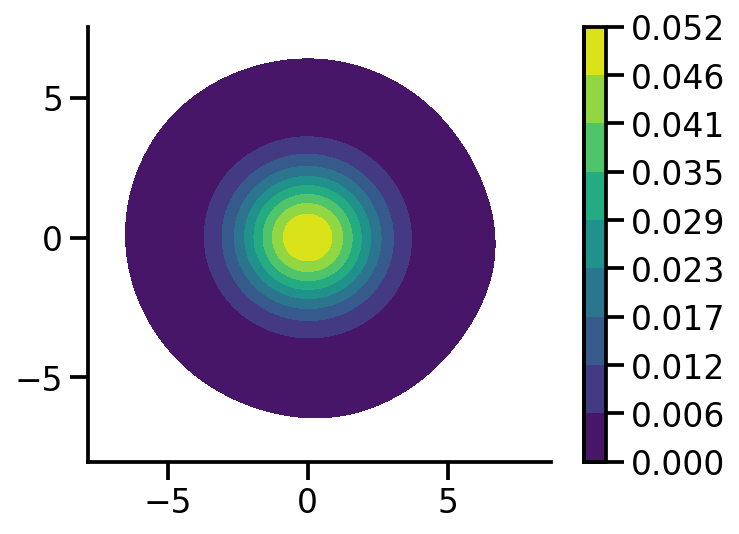

In [15]:
sns.kdeplot(x=X[:, 0],
            y = X[:, 1],zorder=0, n_levels=10, shade=True, 
    cbar=True, thresh=0.001, cmap='viridis',bw_adjust=5,  cbar_kws={'format': '%.3f', })

plt.gca().set_aspect('equal')
sns.despine()

#### Applying the affine transformation

The main difference in the 1d and multivariate case is that instead of using $\sigma$, we use the $L$ cholesky matrix.

In [16]:
mean_2d = tf.constant([3., -1.])
cov = tf.constant([[2., 0.5],
                  [0.5, 1.]])

In [17]:
L = tf.linalg.cholesky(cov)

In [18]:
Y_2d = mean_2d + X@tf.transpose(L)

In [19]:
Y_2d.shape

TensorShape([2000, 2])

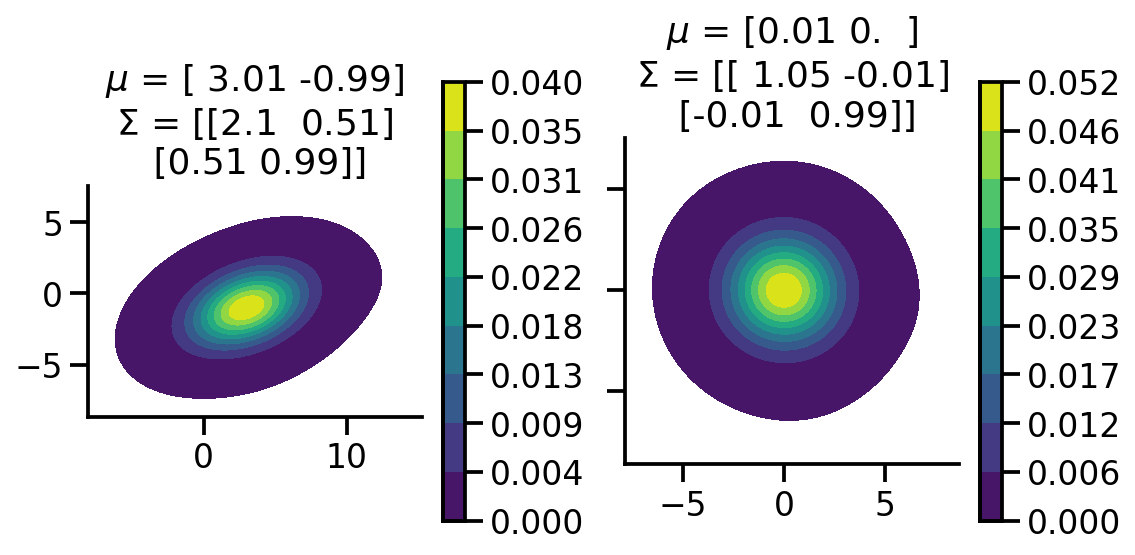

In [20]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(8, 4))
sns.kdeplot(x=Y_2d[:, 0],
            y = Y_2d[:, 1],zorder=0, n_levels=10, shade=True, 
    cbar=True, thresh=0.001, cmap='viridis',bw_adjust=5, ax=ax[0], cbar_kws={'format': '%.3f', })

sns.kdeplot(x=X[:, 0],
            y = X[:, 1],zorder=0, n_levels=10, shade=True, 
    cbar=True, thresh=0.001, cmap='viridis',bw_adjust=5, ax=ax[1], cbar_kws={'format': '%.3f', })

ax[0].set_aspect('equal')
ax[1].set_aspect('equal')

sample_mean_tr = tf.reduce_mean(Y_2d, axis=0).numpy()
sample_mean_tr_rounded  = np.around(sample_mean_tr, 2)

cov_tr = tfp.stats.covariance(Y_2d).numpy()
cov_tr_rounded =np.around(cov_tr, 2)


sample_mean = tf.reduce_mean(X, axis=0).numpy()
sample_mean_rounded  = np.around(sample_mean, 2)

cov = tfp.stats.covariance(X).numpy()
cov_rounded =np.around(cov, 2)


ax[0].set_title(fr"$\mu$ = {sample_mean_tr_rounded}"+"\n"+ fr"$\Sigma$ = {cov_tr_rounded}")
ax[1].set_title(fr"$\mu$ = {sample_mean_rounded}"+"\n"+ fr"$\Sigma$ = {cov_rounded}")



sns.despine()
fig.tight_layout()

References

1. https://www.youtube.com/watch?v=DSWM7-9gK7s&list=PLISXH-iEM4Jm5B_J9p1oUNGDAUeCFZLkJ&index=38
2. https://www.youtube.com/watch?v=4fVQrH65aWU
3. https://en.wikipedia.org/wiki/Box–Muller_transform
4. https://en.wikipedia.org/wiki/Affine_transformation